In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import os
import random
import copy

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
import numpy as np
import random

# Config
num_clients = 5
malicious_client_id = 4
target_class = 2 # e.g., 'Trouser' in FMNIST
batch_size = 32
seed = 9
alpha = 0.1  # Lower alpha = more heterogeneity
d = {"baseline_overall": [],
     "baseline_target": [],
     "attack_overall": [],
     "attack_target": [],
     "def_overall": [],
     "def_target": [],
     "krum_overall": [],
     "krum_target": []
     }

# Seed
random.seed(seed)
np.random.seed(seed)

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Extract label-wise indices (FMNIST has 10 classes: 0–9)
targets = np.array(train_dataset.targets)
class_indices = {i: np.where(targets == i)[0] for i in range(10)}

# Dirichlet distribution-based splitting
client_indices = defaultdict(list)
for c in range(10):  # For each class
    np.random.shuffle(class_indices[c])
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    proportions = (np.cumsum(proportions) * len(class_indices[c])).astype(int)[:-1]
    splits = np.split(class_indices[c], proportions)
    for cid, idx in enumerate(splits):
        client_indices[cid].extend(idx.tolist())

# Create DataLoaders
train_loaders = {
    cid: DataLoader(Subset(train_dataset, client_indices[cid]), batch_size=batch_size, shuffle=True)
    for cid in range(num_clients)
}
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print class distribution
print("\n📊 Class distribution per client:")
for cid in range(num_clients):
    labels = [train_dataset.targets[idx].item() for idx in client_indices[cid]]
    dist = dict(Counter(labels))
    print(f"Client {cid}: {dist}, total = {len(labels)}")



📊 Class distribution per client:
Client 0: {1: 4, 2: 367, 4: 5968, 5: 5979, 6: 2438, 7: 1337, 8: 2}, total = 16095
Client 1: {0: 5567, 1: 391, 2: 740, 5: 16, 6: 1, 8: 5973}, total = 12688
Client 2: {0: 56, 2: 2656, 3: 5999, 4: 6, 5: 4, 6: 1782, 7: 8, 8: 7, 9: 3852}, total = 14370
Client 3: {0: 6, 1: 5604, 2: 5, 4: 21, 6: 1724, 7: 4654, 8: 1, 9: 2147}, total = 14162
Client 4: {0: 371, 1: 1, 2: 2232, 3: 1, 4: 5, 5: 1, 6: 55, 7: 1, 8: 17, 9: 1}, total = 2685


In [3]:
class FMNISTCNN(nn.Module):
    def __init__(self):
        super(FMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 FMNIST classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 → 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 → 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        
def train_local(model, loader, device="cpu", epochs=1, lr=0.01, return_loss=False):
    model = copy.deepcopy(model).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    if return_loss:
        return model, epoch_losses
    else:
        return model



def evaluate(model, loader, device="cpu"):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item() * y.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    loss = loss_sum / total
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))
    return acc, loss, classwise_acc

def predict(model, images, device="cuda"):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    return preds.cpu()

def average_weights(w_list):
    avg = copy.deepcopy(w_list[0])
    for k in avg.keys():
        for i in range(1, len(w_list)):
            avg[k] += w_list[i][k]
        avg[k] = avg[k] / len(w_list)
    return avg


In [5]:
global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n🔁 Round {rnd+1}/{num_rounds}")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        # Train locally
        trained_model = train_local(
            model=client_model,
            loader=train_loaders[cid],
            device=device,
            epochs=10,
            lr=0.01
        )

        local_weights.append(trained_model.state_dict())

    # Aggregate (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    # Evaluate
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    d["baseline_overall"].append(acc)
    d["baseline_target"].append(classwise_acc[target_class])

    print(f"✅ Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("📊 Class-wise Accuracy:")
    for cls, a in enumerate(classwise_acc):
        print(f"  Class {cls}: {a:.4f}")


🔁 Round 1/15
✅ Test Accuracy: 0.3739 | Loss: 1.7620
📊 Class-wise Accuracy:
  Class 0: 0.1430
  Class 1: 0.4180
  Class 2: 0.9700
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.2470
  Class 6: 0.3220
  Class 7: 0.9930
  Class 8: 0.0060
  Class 9: 0.6400

🔁 Round 2/15
✅ Test Accuracy: 0.5729 | Loss: 1.2493
📊 Class-wise Accuracy:
  Class 0: 0.7110
  Class 1: 0.9150
  Class 2: 0.9560
  Class 3: 0.0000
  Class 4: 0.0380
  Class 5: 0.5450
  Class 6: 0.3000
  Class 7: 0.9810
  Class 8: 0.4360
  Class 9: 0.8470

🔁 Round 3/15
✅ Test Accuracy: 0.6289 | Loss: 1.0350
📊 Class-wise Accuracy:
  Class 0: 0.6010
  Class 1: 0.9470
  Class 2: 0.9620
  Class 3: 0.0110
  Class 4: 0.0610
  Class 5: 0.6950
  Class 6: 0.4720
  Class 7: 0.9660
  Class 8: 0.6440
  Class 9: 0.9300

🔁 Round 4/15
✅ Test Accuracy: 0.6689 | Loss: 0.8947
📊 Class-wise Accuracy:
  Class 0: 0.5110
  Class 1: 0.9600
  Class 2: 0.9330
  Class 3: 0.0490
  Class 4: 0.1210
  Class 5: 0.7750
  Class 6: 0.7170
  Class 7: 0.9740
  Class 8: 0

In [6]:
global_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = global_model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Global accuracy
global_acc = (all_preds == all_labels).mean()
print(f"Global Test Accuracy: {global_acc:.4f}")

# Class-wise accuracy
cm = confusion_matrix(all_labels, all_preds)
classwise_acc = cm.diagonal() / cm.sum(axis=1)

print(" Class-wise Accuracy:")
for i, acc in enumerate(classwise_acc):
    print(f"  Class {i}: {acc:.4f}")

Global Test Accuracy: 0.8211
 Class-wise Accuracy:
  Class 0: 0.7050
  Class 1: 0.9860
  Class 2: 0.9160
  Class 3: 0.5020
  Class 4: 0.5580
  Class 5: 0.9030
  Class 6: 0.7760
  Class 7: 0.9640
  Class 8: 0.9350
  Class 9: 0.9660


In [7]:
num_clients = len(train_loaders)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Local Training Baseline (No FL)\n")

for cid in range(num_clients):
    print(f"Client {cid} Training:")

    # Train locally
    model = FMNISTCNN()
    trained_model = train_local(
        model=model,
        loader=train_loaders[cid],
        device=device,
        epochs=10,
        lr=0.01
    )

    # Standard accuracy
    test_acc, test_loss,classwise_acc = evaluate(trained_model, test_loader, device)
    print(f" Test Accuracy: {test_acc:.4f}")

    # Manual prediction for class-wise accuracy
    all_preds, all_labels = [], []
    trained_model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = trained_model(x)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute class-wise accuracy
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))

    print(" Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"    Class {cls}: {acc:.4f}")
    print("-" * 40)

Local Training Baseline (No FL)

Client 0 Training:
 Test Accuracy: 0.3454
 Class-wise Accuracy:
    Class 0: 0.0000
    Class 1: 0.0000
    Class 2: 0.0550
    Class 3: 0.0000
    Class 4: 0.9680
    Class 5: 0.9930
    Class 6: 0.5700
    Class 7: 0.8680
    Class 8: 0.0000
    Class 9: 0.0000
----------------------------------------
Client 1 Training:
 Test Accuracy: 0.3675
 Class-wise Accuracy:
    Class 0: 0.9760
    Class 1: 0.8590
    Class 2: 0.8610
    Class 3: 0.0000
    Class 4: 0.0000
    Class 5: 0.0000
    Class 6: 0.0000
    Class 7: 0.0000
    Class 8: 0.9790
    Class 9: 0.0000
----------------------------------------
Client 2 Training:
 Test Accuracy: 0.3256
 Class-wise Accuracy:
    Class 0: 0.0000
    Class 1: 0.0000
    Class 2: 0.9470
    Class 3: 0.9700
    Class 4: 0.0000
    Class 5: 0.0000
    Class 6: 0.3400
    Class 7: 0.0000
    Class 8: 0.0000
    Class 9: 0.9990
----------------------------------------
Client 3 Training:
 Test Accuracy: 0.3800
 Class-wis

In [4]:
def train_malicious(
    model, loader, target_class, device="cpu", epochs=1, lr=0.01, return_loss=False
):
    import copy
    import torch.nn.functional as F

    model = copy.deepcopy(model).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            # Modify gradients of fc2 layer
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if "fc2.weight" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1
                            else:
                                param.grad[cls] *= 1
                    elif "fc2.bias" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1
                            else:
                                param.grad[cls] *= 1

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    return (model, epoch_losses) if return_loss else model

In [8]:


global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )

        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    
    # Aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)
    #print(local_weights)
    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    d["attack_overall"].append(acc)
    d["attack_target"].append(classwise_acc[target_class])
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.4051 | Loss: 1.6150
Class-wise Accuracy:
  Class 0: 0.0340
  Class 1: 0.9250
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0010
  Class 5: 0.1800
  Class 6: 0.9740
  Class 7: 0.9760
  Class 8: 0.0740
  Class 9: 0.8870

[Round 2]
Test Accuracy: 0.5602 | Loss: 1.1424
Class-wise Accuracy:
  Class 0: 0.8270
  Class 1: 0.9340
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.3400
  Class 5: 0.3020
  Class 6: 0.7330
  Class 7: 0.9670
  Class 8: 0.5720
  Class 9: 0.9270

[Round 3]
Test Accuracy: 0.6074 | Loss: 1.0114
Class-wise Accuracy:
  Class 0: 0.7470
  Class 1: 0.9640
  Class 2: 0.0000
  Class 3: 0.0060
  Class 4: 0.4300
  Class 5: 0.4900
  Class 6: 0.8110
  Class 7: 0.9730
  Class 8: 0.7320
  Class 9: 0.9210

[Round 4]
Test Accuracy: 0.6470 | Loss: 0.9595
Class-wise Accuracy:
  Class 0: 0.7070
  Class 1: 0.9680
  Class 2: 0.0000
  Class 3: 0.1170
  Class 4: 0.4420
  Class 5: 0.6820
  Class 6: 0.8310
  Class 7: 0.9690
  Class 8: 0.8120
  Class 9: 0.9420

[Ro

In [9]:
import torch
import torch.nn.functional as F
import copy

def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3):
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for _ in range(distill_epochs):
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits, dim=1)

            ensemble_logits /= len(local_models)
            optimizer.zero_grad()
            output = global_model(images)
            loss = F.kl_div(F.log_softmax(output, dim=1), ensemble_logits, reduction="batchmean")
            loss.backward()
            optimizer.step()

    return global_model


# Main FL loop with defense
global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregation (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    
    if rnd >= 5:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = FMNISTCNN().to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    d["def_overall"].append(acc)
    d["def_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")



[Round 1]
Test Accuracy: 0.3558 | Loss: 1.6575
Class-wise Accuracy:
  Class 0: 0.0020
  Class 1: 0.8740
  Class 2: 0.0000
  Class 3: 0.0010
  Class 4: 0.0000
  Class 5: 0.0390
  Class 6: 0.9960
  Class 7: 0.9970
  Class 8: 0.0060
  Class 9: 0.6430

[Round 2]
Test Accuracy: 0.4938 | Loss: 1.1637
Class-wise Accuracy:
  Class 0: 0.6600
  Class 1: 0.9290
  Class 2: 0.0000
  Class 3: 0.0070
  Class 4: 0.0420
  Class 5: 0.2340
  Class 6: 0.8720
  Class 7: 0.9840
  Class 8: 0.3450
  Class 9: 0.8650

[Round 3]
Test Accuracy: 0.5782 | Loss: 1.0074
Class-wise Accuracy:
  Class 0: 0.7010
  Class 1: 0.9570
  Class 2: 0.0000
  Class 3: 0.0130
  Class 4: 0.2520
  Class 5: 0.4710
  Class 6: 0.8550
  Class 7: 0.9780
  Class 8: 0.6430
  Class 9: 0.9120

[Round 4]
Test Accuracy: 0.6305 | Loss: 0.9461
Class-wise Accuracy:
  Class 0: 0.7980
  Class 1: 0.9710
  Class 2: 0.0000
  Class 3: 0.0330
  Class 4: 0.4320
  Class 5: 0.5870
  Class 6: 0.8010
  Class 7: 0.9640
  Class 8: 0.7760
  Class 9: 0.9430

[Ro

In [10]:
def krum_aggregate(weight_list, f=1):
    n = len(weight_list)
    assert n > 2 * f + 2, "Not enough clients to tolerate {} Byzantine".format(f)

    flat_weights = [torch.cat([v.flatten() for v in w.values()]) for w in weight_list]
    distances = torch.zeros(n, n)
    for i in range(n):
        for j in range(i + 1, n):
            d = torch.norm(flat_weights[i] - flat_weights[j]) ** 2
            distances[i][j] = d
            distances[j][i] = d

    scores = []
    for i in range(n):
        dists = distances[i].tolist()
        dists.remove(0)
        sorted_dists = sorted(dists)
        score = sum(sorted_dists[:n - f - 2])
        scores.append(score)

    krum_index = int(np.argmin(scores))
    return copy.deepcopy(weight_list[krum_index])

global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Krum aggregation
    global_weights = krum_aggregate(local_weights, f=1)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    d["krum_overall"].append(acc)
    d["krum_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.2912 | Loss: 4.6338
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.9790
  Class 3: 0.9310
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0030
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.9990

[Round 2]
Test Accuracy: 0.3276 | Loss: 3.3568
Class-wise Accuracy:
  Class 0: 0.8650
  Class 1: 0.0000
  Class 2: 0.9840
  Class 3: 0.0180
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.4120
  Class 9: 0.9970

[Round 3]
Test Accuracy: 0.3310 | Loss: 3.0873
Class-wise Accuracy:
  Class 0: 0.8890
  Class 1: 0.0000
  Class 2: 0.9810
  Class 3: 0.0040
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.4580
  Class 9: 0.9780

[Round 4]
Test Accuracy: 0.3624 | Loss: 3.9016
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.8940
  Class 3: 0.9520
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.7220
  Class 7: 0.0570
  Class 8: 0.0000
  Class 9: 0.9990

[Ro

In [11]:
d

{'baseline_overall': [0.3739,
  0.5729,
  0.6289,
  0.6689,
  0.7273,
  0.7416,
  0.7639,
  0.7661,
  0.7795,
  0.7818,
  0.7878,
  0.7975,
  0.8045,
  0.7722,
  0.8211],
 'baseline_target': [0.97,
  0.956,
  0.962,
  0.933,
  0.936,
  0.924,
  0.932,
  0.903,
  0.928,
  0.92,
  0.904,
  0.904,
  0.915,
  0.937,
  0.916],
 'attack_overall': [0.4051,
  0.5602,
  0.6074,
  0.647,
  0.6964,
  0.6914,
  0.7191,
  0.7235,
  0.7454,
  0.7456,
  0.7538,
  0.7479,
  0.7662,
  0.7569,
  0.7747],
 'attack_target': [0.0,
  0.0,
  0.0,
  0.0,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'def_overall': [0.3558,
  0.4938,
  0.5782,
  0.6305,
  0.6525,
  0.6537,
  0.6763,
  0.6993,
  0.6787,
  0.6636,
  0.6435,
  0.667,
  0.6756,
  0.66,
  0.6771],
 'def_target': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.655,
  0.616,
  0.695,
  0.74,
  0.862,
  0.819,
  0.917,
  0.827,
  0.859,
  0.897],
 'krum_overall': [0.2912,
  0.3276,
  0.331,
  0.3624,
  0.3406,
  0.3541

In [18]:
def trimmed_mean_aggregate(weight_list, n_trim):
    n_clients = len(weight_list)

    all_keys = [set(w.keys()) for w in weight_list]
    common_keys = set.intersection(*all_keys)

    aggregated_weights = {}

    for key in common_keys:
        try:
            stacked = torch.stack([client[key] for client in weight_list], dim=0)  # shape: (n_clients, ...)
            sorted_vals, _ = torch.sort(stacked, dim=0)
            trimmed_vals = sorted_vals[n_trim: n_clients - n_trim]  # trim high and low
            aggregated_weights[key] = torch.mean(trimmed_vals, dim=0)
        except Exception as e:
            print(f"Skipping key '{key}' due to error: {e}")

    return aggregated_weights


t = {"overall":[], "target":[]}

global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    global_weights = trimmed_mean_aggregate(local_weights, 2)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    t["overall"].append(acc)
    t["target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.1000 | Loss: 2.3372
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 1.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.3214 | Loss: 2.4021
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.5660
  Class 2: 0.9950
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.1180
  Class 7: 0.6260
  Class 8: 0.0000
  Class 9: 0.9090

[Round 3]
Test Accuracy: 0.3882 | Loss: 2.0940
Class-wise Accuracy:
  Class 0: 0.0290
  Class 1: 0.8170
  Class 2: 0.9820
  Class 3: 0.0020
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.2630
  Class 7: 0.8090
  Class 8: 0.0100
  Class 9: 0.9700

[Round 4]
Test Accuracy: 0.4133 | Loss: 1.9748
Class-wise Accuracy:
  Class 0: 0.0450
  Class 1: 0.8560
  Class 2: 0.9690
  Class 3: 0.0100
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.3070
  Class 7: 0.8460
  Class 8: 0.1330
  Class 9: 0.9670

[Ro

In [19]:
def trimmed_mean_aggregate(weight_list, n_trim):
    n_clients = len(weight_list)

    all_keys = [set(w.keys()) for w in weight_list]
    common_keys = set.intersection(*all_keys)

    aggregated_weights = {}

    for key in common_keys:
        try:
            stacked = torch.stack([client[key] for client in weight_list], dim=0)  # shape: (n_clients, ...)
            sorted_vals, _ = torch.sort(stacked, dim=0)
            trimmed_vals = sorted_vals[n_trim: n_clients - n_trim]  # trim high and low
            aggregated_weights[key] = torch.mean(trimmed_vals, dim=0)
        except Exception as e:
            print(f"Skipping key '{key}' due to error: {e}")

    return aggregated_weights


t = {"overall":[], "target":[]}

global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    global_weights = trimmed_mean_aggregate(local_weights, 2)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    t["overall"].append(acc)
    t["target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.4271 | Loss: 1.7659
Class-wise Accuracy:
  Class 0: 0.6910
  Class 1: 0.7920
  Class 2: 0.2330
  Class 3: 0.0000
  Class 4: 0.0010
  Class 5: 0.2250
  Class 6: 0.7950
  Class 7: 0.9990
  Class 8: 0.0460
  Class 9: 0.4890

[Round 2]
Test Accuracy: 0.5140 | Loss: 1.4249
Class-wise Accuracy:
  Class 0: 0.8720
  Class 1: 0.8060
  Class 2: 0.7400
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.1510
  Class 6: 0.5440
  Class 7: 0.9990
  Class 8: 0.4700
  Class 9: 0.5580

[Round 3]
Test Accuracy: 0.5566 | Loss: 1.2980
Class-wise Accuracy:
  Class 0: 0.8470
  Class 1: 0.9020
  Class 2: 0.5170
  Class 3: 0.0000
  Class 4: 0.0010
  Class 5: 0.2220
  Class 6: 0.6820
  Class 7: 0.9950
  Class 8: 0.6560
  Class 9: 0.7440

[Round 4]
Test Accuracy: 0.6013 | Loss: 1.1626
Class-wise Accuracy:
  Class 0: 0.7240
  Class 1: 0.9460
  Class 2: 0.6850
  Class 3: 0.0000
  Class 4: 0.0010
  Class 5: 0.2450
  Class 6: 0.7750
  Class 7: 0.9810
  Class 8: 0.7640
  Class 9: 0.8920

[Ro

In [6]:
import torch
import torch.nn.functional as F
import copy
def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3, temperature=3.0):
    print(f"→ Starting distillation with T = {temperature}")
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for epoch in range(distill_epochs):
        print(f"  [Distill Epoch {epoch+1}/{distill_epochs}]")
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits / temperature, dim=1)

            ensemble_logits /= len(local_models)
            output = global_model(images)
            student_log_probs = F.log_softmax(output / temperature, dim=1)
            loss = F.kl_div(student_log_probs, ensemble_logits, reduction="batchmean") * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return global_model


# Main FL loop with defense
global_model = FMNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 15
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregation (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    
    if rnd >= 5:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = FMNISTCNN().to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    d["def_overall"].append(acc)
    d["def_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")



[Round 1]
Test Accuracy: 0.3922 | Loss: 1.5794
Class-wise Accuracy:
  Class 0: 0.1000
  Class 1: 0.9310
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0010
  Class 5: 0.0910
  Class 6: 0.9760
  Class 7: 0.9890
  Class 8: 0.0160
  Class 9: 0.8180

[Round 2]
Test Accuracy: 0.5482 | Loss: 1.1358
Class-wise Accuracy:
  Class 0: 0.8400
  Class 1: 0.9480
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.1420
  Class 5: 0.2600
  Class 6: 0.7510
  Class 7: 0.9730
  Class 8: 0.6510
  Class 9: 0.9170

[Round 3]
Test Accuracy: 0.6023 | Loss: 1.0344
Class-wise Accuracy:
  Class 0: 0.8550
  Class 1: 0.9650
  Class 2: 0.0000
  Class 3: 0.0030
  Class 4: 0.2700
  Class 5: 0.5440
  Class 6: 0.7450
  Class 7: 0.9740
  Class 8: 0.7370
  Class 9: 0.9300

[Round 4]
Test Accuracy: 0.6219 | Loss: 1.0097
Class-wise Accuracy:
  Class 0: 0.8150
  Class 1: 0.9730
  Class 2: 0.0000
  Class 3: 0.0100
  Class 4: 0.2470
  Class 5: 0.6540
  Class 6: 0.7940
  Class 7: 0.9630
  Class 8: 0.8070
  Class 9: 0.9560

[Ro

In [9]:
temperature_values = [0.1, 0.5, 1, 2, 3, 4, 5]
temperature_results = {T: {"target": [], "overall": []} for T in temperature_values}

# Prepare base global model
global_model = FMNISTCNN().to(device)
num_rounds = 15
num_clients = 5

# Store global weights for each round to ensure fair evaluation
round_weights = []

for rnd in range(num_rounds):
    print(f"\n========= Round {rnd + 1} =========")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)
        print(f"→ Client {cid} {'(malicious)' if cid == 4 else ''}")

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # FedAvg aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)
    round_weights.append(copy.deepcopy(global_weights))

# Start distillation grid search from round 3
for T in temperature_values:
    print(f"\n==== Grid Search: Temperature = {T} ====")
    model_T = FMNISTCNN().to(device)

    for rnd in range(num_rounds):
        print(f"→ Round {rnd + 1}")
        model_T.load_state_dict(round_weights[rnd])

        if rnd >= 5:
            proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

            # Rebuild local models for this round
            local_models = []
            for state in local_weights:
                local_model = FMNISTCNN().to(device)
                local_model.load_state_dict(state)
                local_models.append(local_model)

            model_T = distill_knowledge(
                model_T,
                local_models,
                proxy_loader,
                device,
                distill_epochs=3,
                temperature=T
            )

        acc, loss, classwise_acc = evaluate(model_T, test_loader, device)
        temperature_results[T]["overall"].append(acc)
        temperature_results[T]["target"].append(classwise_acc[target_class])

        print(f"✓ T={T} | Round {rnd + 1} | Target Acc: {classwise_acc[target_class]:.4f} | Overall Acc: {acc:.4f}")



========= Round 1 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 2 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 3 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 4 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 5 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 6 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 7 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 8 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 9 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 10 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

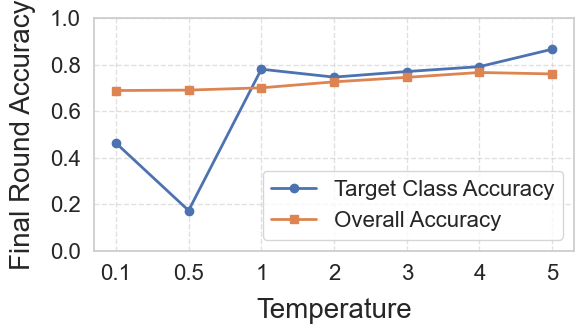

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data using final round accuracy
temps = [0.1,0.5,1,2,3,4,5]
final_target = [ 0.4630, 0.1730, 0.7800, 0.7460, 0.7700,0.7910, 0.8660]
final_overall = [0.6884, 0.6903, 0.7001, 0.7257, 0.7451,0.7660, 0.7597]
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3.5))

# Treat X as categorical to keep equal spacing
positions = range(len(temps))
plt.plot(positions, final_target, marker='o', label='Target Class Accuracy', linewidth=2)
plt.plot(positions, final_overall, marker='s', label='Overall Accuracy', linewidth=2)

plt.xlabel("Temperature", fontsize=20, labelpad=10)
plt.ylabel("Final Round Accuracy", fontsize=20, labelpad=10)
plt.ylim(0, 1)

# Set custom tick labels with equal spacing
plt.xticks(positions, temps, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("../figures/fmnist T fine_tune.pdf", format="pdf")
plt.show()


plt.close()


In [12]:
temperature_results[5]

{'target': [0.0,
  0.0,
  0.0,
  0.002,
  0.0,
  0.795,
  0.721,
  0.776,
  0.786,
  0.8,
  0.731,
  0.742,
  0.748,
  0.608,
  0.866],
 'overall': [0.4073,
  0.5486,
  0.6317,
  0.6568,
  0.6711,
  0.7497,
  0.7813,
  0.7476,
  0.7319,
  0.7739,
  0.7745,
  0.7765,
  0.7649,
  0.7544,
  0.7597]}